<h1> Random Forest Modelling </h1> <br>
This notebook builds 3 types of random forests: an H2O random forest, an sklearn random forest, and an ensemble of random forests built on bootstrapped character data. We try these three approaches with different pre-processing settings (tfidf vs. no tfidf), and achieve a maximum OOS accuracy of 91% with a random forest on tfidf data.

<h3> Preprocessing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

# User imports
import load_data as ld
import feature_extract
import classifiers.decision_tree as dt
import classifiers.naive_bayes as nb
import classifiers.random_forest as rf

In [ ]:
def done(): 
    print("Done.\n")

def get_features(x_file, y_file):
    print("Loading data sets...")

    X_raw = ld.load(x_file)
    y = ld.load(y_file)

    done()

    print("Extracting features...")

    # Extract features into letter frequencies
    X, features = feature_extract.vectorize_letters(X_raw, 1)

    done()

    # Since we are likely going to manipulate X by rows (when splitting), we return a csr copy
    return X.tocsr(), y, features


def real_train(classifier, X, y, features):
    classifier.train(X, y)
    
    # Testing on the test file
    X_test_raw = ld.load('./data/test_set_x.csv')
    X_test = feature_extract.extract_chars_raw(X_test_raw, features)

    if hasattr(classifier, "classify_multithread"):
        print("Multithreaded classify...")
        y_res = classifier.classify_multithread(X_test, 4)
    else:
        print("Classifying...")
        y_res = classifier.classify(X_test)

    # Write result in csv file
    ld.write(y_res, './results/test_set_y.csv')


def test(classifier, X, y):
    """Test one classifier on one split of the X set.
    Return the accuracy
    """

    nbsamples = X.shape[0]
    #Split into test and training
    train_pct = nbsamples // 5
    split = nbsamples - train_pct
    X_train = X[:split]
    X_test = X[split:]

    y_train = y[:split]
    y_test = y[split:]

    print("Training classifier...")

    classifier.train(X_train, y_train)

    done()

    if hasattr(classifier, "classify_multithread"):
        print("Multithreaded classify...")
        y_res = classifier.classify_multithread(X_test, 4)
    else:
        print("Classifying...")
        y_res = classifier.classify(X_test)

    done()

    # Return the accuracy
    return (np.count_nonzero(y_res == y_test) / len(y_res)), y_res


def train_kfold(X, y, nb_folds, classifiers):
    """Train a list of classifiers using k-fold validation
    and return the best classifier and the accuracy
    """

    kf = KFold(nb_folds, True)

    accuracies = np.zeros(len(classifiers))
    kfold_idx = 1

    for train_idx, test_idx in kf.split(X):
        print("Training with kfold {0}...".format(kfold_idx))

        # Split into test and training
        X_train = X[train_idx]
        X_test = X[test_idx]

        y_train = y[train_idx]
        y_test = y[test_idx]

        for i, classifier in enumerate(classifiers):
            classifier.train(X_train, y_train)
            y_res = classifier.classify(X_test)
            accuracies[i] += (np.count_nonzero(y_res == y_test) / len(y_res)) / nb_folds

        done()
        kfold_idx += 1


    # Pick the best classifier
    winner = None
    accuracy = 0.0
    for i, acc in enumerate(accuracies):
        if acc > accuracy:
            accuracy = acc
            winner = classifiers[i]

    return winner, accuracy


In [243]:
X, y, ft = get_features('./data/chars_train_set_x.csv', './data/train_set_y.csv')

Loading data sets...
Done.

Extracting features...
Done.



In [5]:
#vectorizing on small character training set
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='char', smooth_idf=False)
raw = pd.read_csv('./data/chars_train_set_x.csv', keep_default_na=False, encoding='utf-8')
raw_list = [i for i in raw['Text'].astype(str).values]
X_tfidf1 = vectorizer.fit_transform(raw_list)

In [6]:
#vectorizing on full character training set
raw2 = pd.read_csv('./data/train_set_x.csv', keep_default_na=False, encoding='utf-8')['Text'].values
X_tfidf2 = vectorizer.fit_transform(raw2)

In [258]:
#remove nans
nan_idx_list=[]
for i,k in zip(raw_list, range(len(raw_list))):
    if(i=='nan'):
        nan_idx_list.append(k)
        raw_list.remove(i)

In [7]:
#remove corresponding Ys
y = pd.read_csv('./data/train_set_y.csv')[['Category']].values
#y=np.delete(y,nan_idx_list)

Bootstrap samples

In [35]:
import load_data as ld
import random
import re

spaces = re.compile('\s+')

def extract_random_chars(x_raw):
    new_x = []
    spaces = re.compile('\s+')
    
    
    for sentence in x_raw:
        temp = spaces.sub('', sentence.lower())

        nbwords = len(sentence.split())
        nbchars = len(temp)
        nbsamples = min(2*nbwords, nbchars)    

        chars = random.sample(temp, nbsamples)
    
        # Get 20 random letters from the set of characters
        new_x.append(' '.join(chars))

    return new_x

#shuffle x_raw and y identically
X_raw = ld.load("./data/train_set_x.csv")
y = pd.read_csv('./data/train_set_y.csv')[['Category']].values
c = list(zip(X_raw, y))
random.shuffle(c)
X_raw, y = zip(*c)

for i in range(10):
    new_x = extract_random_chars(X_raw)
    ld.write(new_x, './data/chars_train_set_x'+str(i)+'.csv','Id,Text')

tfidf modelling (bootstrap and no bootstrap) - Random Forest

In [64]:
from scipy import sparse
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

def nb_tfidf_bootstrap(n, y):
    #based on a bootstrapped sample (see above), build n estimators and combine them.
    paths = ['./data/chars_train_set_x'+str(k)+'.csv' for k in range(n)]
    bootstrap_preds=pd.DataFrame()

    for i in range(n):
        path=paths[i]
        best_a, best_acc, best_preds = nb_tfidf('normal', y, x_path=path)
        bootstrap_preds[i]=best_preds
    bootstrap_preds['pred']=bootstrap_preds.mode(axis=1)[0]
    return bootstrap_preds

def nb_tfidf(sample, y, x_path=''):
    vectorizer = TfidfVectorizer(analyzer='char', smooth_idf=False)
    
    if(sample == 'tfidf_normal'):
        if(len(x_path)==0):
            x_path='./data/train_set_x.csv'
        raw2 = pd.read_csv(x_path, keep_default_na=False, encoding='utf-8')['Text'].values
        for i in range(len(raw2)):
            raw2[i]=raw2[i].replace(" ","")
        X = vectorizer.fit_transform(raw2)
        
    elif(sample =='tfidf_sub_sample'):
        if(len(x_path)==0):
            x_path='./data/chars_train_set_x.csv'
        raw = pd.read_csv(x_path, keep_default_na=False, encoding='utf-8')
        raw_list = [i for i in raw['Text'].astype(str).values]
        X = vectorizer.fit_transform(raw_list)

    elif(sample == 'normal'):
        if(len(x_path)==0):
            x_path='./data/chars_train_set_x.csv'
        X, y, ft = get_features(x_path, './data/train_set_y.csv')
        y = y.reshape((len(y),1))
        
    #build test/train, split size is 0.2. Transfer to pandas df for now, could optimize with a sparse
    xy = sparse.hstack((X, y)).A
    xy_train = xy[:int(xy.shape[0]*0.8),:]
    xy_test = xy[int(xy.shape[0]*0.8):,:]
    xy_train_pd = pd.DataFrame(xy_train)
    xy_test_pd = pd.DataFrame(xy_test)
    xy_train_pd.rename(columns={xy_train_pd.shape[1]-1 :'lang'}, inplace=True)
    xy_test_pd.rename(columns={xy_train_pd.shape[1]-1 :'lang'}, inplace=True)
    print(xy_train_pd['lang'].head(15))

    feat = [c for c in xy_train_pd.columns if c not in ['lang']]
    #print('starting training')
    best_acc=0
    best_a=0
    best_preds=[]
    
    rf = RandomForestClassifier(n_estimators=400)
    rf.fit(X=xy_train_pd[feat] , y=xy_train_pd['lang'])
    preds=rf.predict(xy_test_pd[feat])
    true=xy_test_pd['lang']
    acc=sklearn.metrics.accuracy_score(preds, true)
    if(acc>best_acc):
        best_acc=acc
        best_a=a
        best_preds = [c for c in preds]
        
    return best_acc, best_a, best_preds

In [ ]:
# run bootstrap samples model (interrupted to run on a server)
df = nb_tfidf_bootstrap(8, y)

Exporting data

In [2]:
import pandas as pd
df1 = pd.read_csv('./test_preds.csv')
df1.columns=['Id', 'Category']
df1.Category = df1.Category.astype(int)
df1.drop('Id', axis=1, inplace=True)
df1.index.name = 'Id'
df1.to_csv('test_preds.csv')

Model validation

In [4]:
c_matrix=[[ 2510,   167,   128,    14,    12],
         [   29,  26871,   986,   180,    19],
         [   43,   2085, 11707,   219,    25],
         [   23,    378,   333,  6641,    18],
         [   20,     61,    93,    27,  2715]]

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
#since this was run on an external server with no python notebooks, we provide only the data here. The code used
# to generate this data is in "trainfile_for_mozart.py"
tree_data=[(25,0.8998), (50,.9075), (100,.9098), (250, .9112), (500,.9122), (1000, .9121)]
x = [i[0] for i in tree_data]
y= [ i[1] for i in tree_data]
plt.plot(x,y)
plt.title('Out of sample accuracy vs number of trees, on TFIDF data')
plt.xlabel('number of trees')
plt.ylabel('Test accuracy score')

<h3> Appendix

H2O Random forest on non tf-idf pre-processed characters. H2O is a predictive modelling package. We tried a rf and a GBM, but neither surpassed sklearn's package performance. Because of the larger computational costs, we abandonned this method.

In [8]:
import h2o
h2o.init(max_mem_size='2G')
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.__PROGRESS_BAR__=False
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -------------------------------
H2O cluster uptime:         4 hours 12 mins
H2O cluster version:        3.10.0.9
H2O cluster version age:    11 months and 15 days !!!
H2O cluster name:           H2O_from_python_Baptiste_k090tb
H2O cluster total nodes:    1
H2O cluster free memory:    1.295 Gb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
Python version:             3.5.4 final
--------------------------  -------------------------------

In [ ]:
import scipy.sparse as sp

Test/train split

In [10]:
X_h2o = h2o.H2OFrame(X_tfidf)
y_h2o = h2o.H2OFrame(y).asfactor()
xy_h2o = X_h2o.cbind(y_h2o)

NameError: name 'X_tfidf' is not defined

In [192]:
#test train
train,test,valid = xy_h2o.split_frame(ratios=(.7, .15))

In [193]:
feat=[c for c in train.col_names if c not in ['C1100']]

In [194]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator

In [197]:
#naive bayes
param_grid_nb = {
             'laplace':[1,5,10] 
             }

nb = H2ONaiveBayesEstimator(laplace=5)
nb.train(x=feat, y='C1100', training_frame=train)
#nb_grid = H2OGridSearch(nb, param_grid_nb)
#nb_grid.train(x=feat, y='C1100', training_frame=train, validation_frame=test)

In [182]:
import sklearn.metrics
best_m=h2o.get_model(nb_grid.model_ids[1])
preds = best_m.predict(train[feat]).as_data_frame()
true = np.array(train['C1100'].as_data_frame()).flatten()
final_preds = preds['predict'].values
sklearn.metrics.accuracy_score(true,final_preds)

0.059047062262496348

In [127]:
#nb_grid.model_performance(test_data=h2o_val)

In [9]:
#grid 3.
param_grid3 = {'max_depth':[5, 12, 20],
              'mtries':[20, 40]}

gbm_grid3 = H2ORandomForestEstimator(ntrees=300)

grid3 = H2OGridSearch(gbm_grid3,param_grid3,search_criteria ={'strategy': "Cartesian"}) #cartesian = try everything

grid3.train(x=feat, 
           y='C1100',
           training_frame = h2o_train,
           validation_frame=h2o_val)

In [24]:
grid3.models[0]

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  Grid_DRF_py_4_sid_b991_model_python_1508212927954_1_model_5
Model Summary: 


number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                1500                        3.35977e+07            20           20           20            206           4117          1761.47



ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.11265899273185213
RMSE: 0.33564712531444707
LogLoss: 0.3622382904166253
Mean Per-Class Error: 0.12618951536601264
Confusion Matrix: vertical: actual; across: predicted



0      1       2      3      4      Error      Rate
-----  ------  -----  -----  -----  ---------  ----------------
9963   714     605    34     60     0.124209   1 413 / 11 376
161    107123  4752   845    73     0.0516228  5 831 / 112 954
190    11563   43076  1003   74     0.229492   12 830 / 55 906
85     2167    1528   25912  74     0.129477   3 854 / 29 766
75     419     484    100    10134  0.096147   1 078 / 11 212
10474  121986  50445  27894  10415  0.11304    25 006 / 221 214

Top-5 Hit Ratios: 


k    hit_ratio
---  -----------
1    0.88696
2    0.972253
3    0.993924
4    0.998689
5    1


ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.11214022554814955
RMSE: 0.3348734470634385
LogLoss: 0.3605041001240951
Mean Per-Class Error: 0.12605632267607647
Confusion Matrix: vertical: actual; across: predicted



0     1      2      3     4     Error      Rate
----  -----  -----  ----  ----  ---------  --------------
2448  188    125    12    18    0.122895   343 / 2 791
46    26840  1211   218   14    0.052561   1 489 / 28 329
45    2898   10849  257   19    0.228817   3 219 / 14 068
24    525    397    6295  7     0.131485   953 / 7 248
21    109    122    19    2596  0.0945239  271 / 2 867
2584  30560  12704  6801  2654  0.113466   6 275 / 55 303

Top-5 Hit Ratios: 


k    hit_ratio
---  -----------
1    0.886534
2    0.972316
3    0.993942
4    0.99868
5    1

Scoring History: 


timestamp            duration           number_of_trees    training_rmse        training_logloss     training_classification_error    validation_rmse      validation_logloss    validation_classification_error
---  -------------------  -----------------  -----------------  -------------------  -------------------  -------------------------------  -------------------  --------------------  ---------------------------------
     2017-10-17 01:02:34  59 min  3.954 sec  0.0                nan                  nan                  nan                              nan                  nan                   nan
     2017-10-17 01:02:40  59 min  9.877 sec  1.0                0.37130875800056184  1.4073178135254476   0.16119912978281445              0.37050158208174355  1.3613162480688084    0.16183570511545486
     2017-10-17 01:02:45  59 min 15.266 sec  2.0                0.3670044715187409   1.136043516656684    0.15655746974780413              0.34832363975522096  0.5585247443716809    0.1359962389020487
     2017-10-17 01:02:51  59 min 21.001 sec  3.0                0.36283733869531226  1.000343658584243    0.15168763609968547              0.34185567411894846  0.448055546018207     0.12755185071334285
     2017-10-17 01:02:57  59 min 26.706 sec  4.0                0.3582162195261147   0.8609748977924021   0.14617360096277832              0.33886234882435073  0.4045720625780854    0.12144006654250221
---  ---                  ---                ---                ---                  ---                  ---                              ---                  ---                   ---
     2017-10-17 01:18:32  1:15:01.422        170.0              0.33604178074132024  0.3630143785549862   0.11366369217138156              0.33511996162333824  0.36092990270849273   0.11341156899264054
     2017-10-17 01:21:12  1:17:42.094        198.0              0.3356808886443994   0.36231173016568363  0.11330657191678646              0.3347903673345604   0.36028398799070077   0.11373704862304033
     2017-10-17 01:24:21  1:20:51.271        231.0              0.33559100184334445  0.3621500891499852   0.1132613668212681               0.3347547591380908   0.3602502251063062    0.11348389779939605
     2017-10-17 01:28:06  1:24:36.311        271.0              0.33554892517840673  0.3620233077704725   0.11301273879591707              0.33475388749138146  0.3602412685698657    0.11333924018588504
     2017-10-17 01:31:01  1:27:31.266        300.0              0.33564712531444707  0.3622382904166253   0.11303986185322809              0.3348734470634385   0.3605041001240951    0.11346581559770717


See the whole table with table.as_data_frame()
Variable Importances: 


variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  --------------------
C243        1439797.0              1.0                  0.07227088958649436
C108        1408229.0              0.9780746869176696   0.07068632770557194
C271        963340.0625            0.669080476275475    0.04835504122538391
C358        880059.6875            0.6112387284457462   0.04417476665449173
C273        727450.3125            0.5052450536429789   0.036514509485954146
---         ---                    ---                  ---
C386        0.0                    0.0                  0.0
C388        0.0                    0.0                  0.0
C397        0.0                    0.0                  0.0
C404        0.0                    0.0                  0.0
C406        0.0                    0.0                  0.0


See the whole table with table.as_data_frame()


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

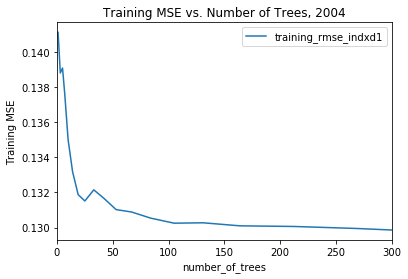

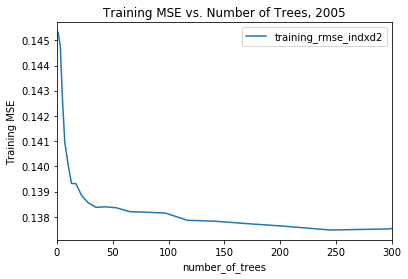

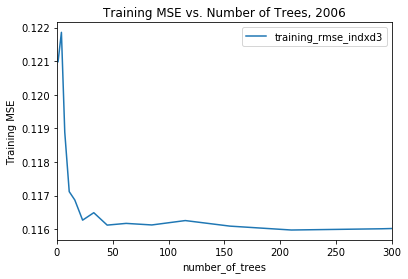

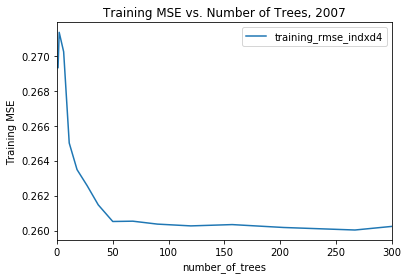

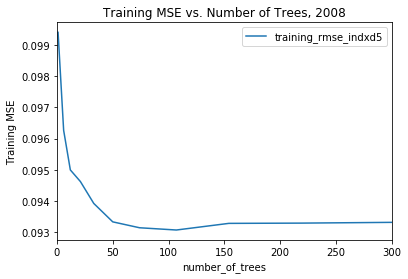

In [23]:
#docs do not specify how training mse is calculated, but we can assume it is on bootstrapped samples.
scoring_avg=None
for saved_model,i in zip(grid3.models, range(len(grid3.models))):
    scoring = pd.DataFrame(saved_model.scoring_history())[['number_of_trees', 'training_rmse']]
    scoring['training_rmse_indxd']=scoring['training_rmse']/scoring.iloc[2,0] #index at first rmse
    scoring.rename(columns={'training_rmse_indxd':'training_rmse_indxd'+str(i)}, inplace=True)
    scoring.drop('training_rmse', axis=1, inplace=True)
    plt.figure()
    scoring.plot(x='number_of_trees', y='training_rmse_indxd'+str(i))
    plt.title('Training MSE vs. Number of Trees, '+ str(i+2003))
    plt.ylabel('Training MSE')
    plt.show()
    if(scoring_avg is not None):
        scoring_avg = pd.merge(scoring_avg, scoring, on='number_of_trees', how='outer')
    else:
        scoring_avg=scoring


In [34]:
best_m=h2o.get_model(grid3.model_ids[0])

In [46]:
preds = best_m.predict(h2o_val[feat]).as_data_frame()
true = np.array(h2o_val['C1100'].as_data_frame()).flatten()

In [49]:
final_preds = preds['predict'].values

In [56]:
import sklearn.metrics
sklearn.metrics.accuracy_score(true,final_preds)

0.88653418440229281

In [61]:
#load and preprocess test
X_test_raw = ld.load('./data/test_set_x.csv')
X_test = feature_extract.extract_chars_raw(X_test_raw, features)
X_test_h2o=h2o.H2OFrame(X_test)

In [94]:
preds=best_m.predict(X_test_h2o).as_data_frame()
pr_export=preds.reset_index()[['index','predict']]
pr_export.columns=['Id','Category']
pr_export.index=pr_export.Id
pr_export.to_csv('rf_300t.csv')

In [82]:
pr_export.drop('Id', axis=1, inplace=True)